    Pré-processamento

In [58]:
import pandas as pd
import openpyxl
from sklearn.model_selection import cross_val_score, KFold, train_test_split,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,auc,accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

In [37]:
#Pré Processamento

#Mapeamento de Area Metropolitana
def mapeamento(row):
    if row['EST_MSA'] == 'New York-Newark-Jersey City, NY-NJ-PA Metro Area':
        return 35620
    elif row['EST_MSA'] == 'Detroit-Warren-Dearborn, MI Metro Area':
        return 19820
    elif row['EST_MSA'] == 'Los Angeles-Long Beach-Anaheim, CA Metro Area':
        return 31080
    elif row['EST_MSA'] == 'Chicago-Naperville-Elgin, IL-IN-WI Metro Area':
        return 16980
    elif row['EST_MSA'] == 'Dallas-Fort Worth-Arlington, TX Metro Area':
        return 19100
    elif row['EST_MSA'] == 'Houston-The Woodlands-Sugar Land, TX Metro Area':
        return 26420
    elif row['EST_MSA'] == 'Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area':
        return 47900
    elif row['EST_MSA'] == 'Miami-Fort Lauderdale-Pompano Beach, FL Metro Area':
        return 33100
    elif row['EST_MSA'] == 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area':
        return 37980
    elif row['EST_MSA'] == 'Atlanta-Sandy Springs-Alpharetta, GA Metro Area':
        return 12060
    elif row['EST_MSA'] == 'Phoenix-Mesa-Chandler, AZ Metro Area':
        return 38060
    elif row['EST_MSA'] == 'Boston-Cambridge-Newton, MA-NH Metro Area':
        return 14460
    elif row['EST_MSA'] == 'San Francisco-Oakland-Berkeley, CA Metro Area':
        return 41860
    elif row['EST_MSA'] == 'Riverside-San Bernardino-Ontario, CA Metro Area':
        return 40140
    elif row['EST_MSA'] == 'Seattle-Tacoma-Bellevue, WA Metro Area':
        return 42660
    elif row['EST_MSA'] > 0:
        return row['EST_MSA']
    else:
        return 0

df = pd.read_excel('dataset.xlsx', skiprows=2)
df['EST_MSA'] = df.apply(mapeamento,axis=1)

#Remoção de mês de nascimento para padronização
df['TBIRTH_YEAR'] = df['TBIRTH_YEAR'].astype(str).str.split("-").str[0]

#Mapeamento de Região
def regionMapping(row):
    if row['EST_ST'] in (9,23,25,33,34,36,42,44,50):
        return 1
    elif row['EST_ST'] in (1,5,10,11,12,13,21,22,24,28,37,40,45,47,48,51,54):
        return 2
    elif row['EST_ST'] in (18,17,19,20,26,27,29,31,38,39,46,55):
        return 3
    elif row['EST_ST'] in (2,4,6,8,15,16,30,32,35,41,49,53,56):
        return 4
    else:
        return ""

df['REGION'] = df.apply(regionMapping,axis=1)

#Binarização remoto ou não
def remoteBinary(row):
    if row['TWDAYS_RESP'] in (1,3):
        return 1
    else:
        return 0

#Binarização de INCOME
def incomeBinary(row):
    if row['INCOME'] in (1,2,3,4):
        return 0
    else:
        return 1

df['IS_RMT'] = df.apply(remoteBinary,axis=1)
df['INCOME'] = df.apply(incomeBinary,axis=1)

df.to_excel('resultado.xlsx', index=False)
print("Feito")

Feito


Separação do database - Validação (30%) / Análise Exploratória (10%) / Teste (60%)

In [38]:
train, temp = train_test_split(df, test_size=0.4, random_state=42)
test, explore = train_test_split(temp, test_size=0.25, random_state=42)

# Divide por classe
explore_rmt_1 = explore[explore['IS_RMT'] == 1]
explore_rmt_0 = explore[explore['IS_RMT'] == 0]

# Identifica minoria e maioria
min_class = 1 if len(explore_rmt_1) < len(explore_rmt_0) else 0

minority = explore_rmt_1 if min_class == 1 else explore_rmt_0
majority = explore_rmt_0 if min_class == 1 else explore_rmt_1

# Oversampling da minoria
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

# Junta e embaralha
explore_balanced = pd.concat([majority, minority_upsampled])
explore_balanced = explore_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Exporta
explore_balanced.to_excel('dados_exploratorios_balanceados_oversampling.xlsx', index=False)

Balanceamento de classes - conjunto treino

In [52]:
# Divide por classe
df_rmt_1 = df[df['IS_RMT'] == 1]
df_rmt_0 = df[df['IS_RMT'] == 0]

# Identifica o grupo menor
min_class = 1 if len(df_rmt_1) < len(df_rmt_0) else 0

# Define os grupos
minority = df_rmt_1 if min_class == 1 else df_rmt_0
majority = df_rmt_0 if min_class == 1 else df_rmt_1

# Oversampling da minoria
minority_oversampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

# Junta os dois grupos balanceados
df_balanced = pd.concat([majority, minority_oversampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


Treinamento de modelo de regressão logística: **É possível prever o salário a partir da forma de trabalho?**

In [69]:
X_train = pd.get_dummies(train_balanced[['INCOME']], drop_first=True)
y_train = train_balanced['IS_RMT']

X_test = pd.get_dummies(test[['INCOME']], drop_first=True)
y_test = test['IS_RMT']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.63      0.74      2359
           1       0.37      0.76      0.50       682

    accuracy                           0.66      3041
   macro avg       0.64      0.70      0.62      3041
weighted avg       0.78      0.66      0.69      3041



Criação de matriz de confusão p/ regressão logística

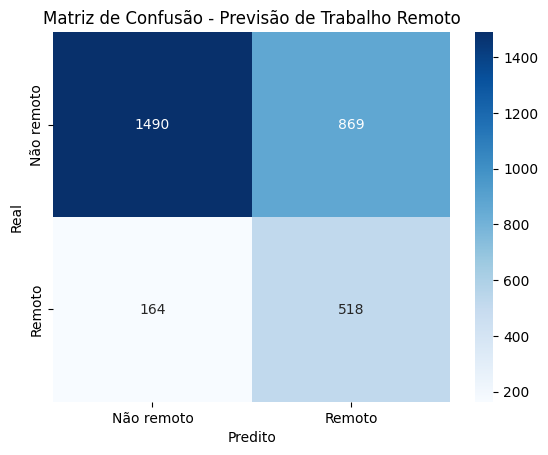

In [71]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não remoto', 'Remoto'],
            yticklabels=['Não remoto', 'Remoto'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Previsão de Trabalho Remoto")
plt.show()

Criação da curva ROC

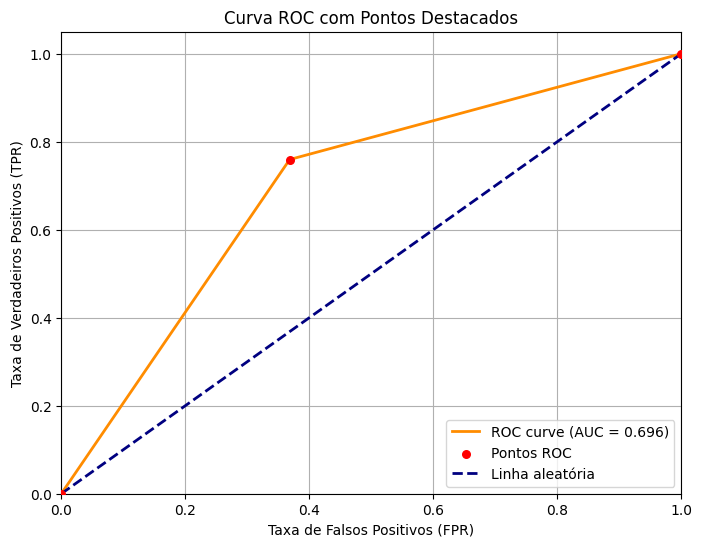

In [72]:
y_prob = logreg.predict_proba(X_test)[:, 1]

# Calculo do FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))

# Plot ds curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')

# Plota os pontos da curva ROC com marcadores
plt.scatter(fpr, tpr, color='red', s=30, zorder=5, label='Pontos ROC')

# Linha aleatória
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Linha aleatória')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC com Pontos Destacados')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()